## Part 1 Build Dataset

In [1]:
import tools
import pickle
import numpy as np

def make_sorted_list_and_save(days):
    pickle_in = open("stock_price_dict.pickle","rb")
    price_dict_ = pickle.load(pickle_in)
    #DATA_DIR = 'D:\Dataset\EarningsCallData\ReleasedDataset\ReleasedDataset_mp3'
    DATA_DIR = '.\EarningsCallData\ACL19_Release\ACL19_Release'
    stock_movement_3days, text_all, date, company = tools.calculate_movement(price_dict_, days, DATA_DIR)
    print(len(stock_movement_3days), len(text_all), len(date))

    combined_list = list(zip(date, stock_movement_3days, company, text_all)) #进行数据的聚合、组合或并行处理。
    print(len(combined_list))
    sorted_list = sorted(combined_list, key=lambda x: x[0])#按照列表中元素的第一个索引（日期）进行排序

    np.save(f'sorted_list_{days}days.npy', sorted_list)

def make_and_save(days):
    make_sorted_list_and_save(days)

if __name__ == "__main__":
    print()
    make_and_save(3)

  5%|▍         | 27/572 [00:00<00:06, 86.06it/s]

Error Company: Aetna IncDate: 2017-01-31
Error Company: Aetna IncDate: 2017-05-02
Error Company: Aetna IncDate: 2017-10-31


 18%|█▊        | 103/572 [00:01<00:04, 104.66it/s]

Error Company: CA, Inc.Date: 2017-08-02


 99%|█████████▉| 565/572 [00:05<00:00, 104.03it/s]

Error Company: Vulcan MaterialsDate: 2017-08-02


100%|██████████| 572/572 [00:05<00:00, 108.37it/s]


24.237429941531154
563 563 563
563


## Part 2 Token-Level Encoder

In [3]:
import transformers
from tqdm import tqdm #用于在循环迭代中显示进度条的库
import torch
import re

#Generate sentence representation 使用预训练的语言模型来计算文本的嵌入表示
def emb_str(text):
    input_ids = torch.tensor([tokenizer.encode(text)])[:,:512] #使用 tokenizer 对文本进行编码，将其转换为输入张量 input_ids。编码后的张量可能会被裁剪为最大长度512。
    # print(input_ids.shape)
    with torch.no_grad(): #是一个上下文管理器，用于在执行期间禁用梯度计算。在这个上下文中，所有的张量操作都不会被跟踪，也不会导致梯度被计算和存储。这在进行推断或评估时非常有用，因为在这些情况下通常不需要计算梯度。
        last_hidden_states = model(input_ids)[0]  # Models outputs are now tuples 使用模型对输入张量进行前向传递，获得最后一层隐藏状态 只取第一个元素
        emb = last_hidden_states.cpu().numpy() #将最后一层隐藏状态转移到 CPU 上，并将其转换为 NumPy 数组
    return emb
import re
        
# Padding
def make(days,name):
    list = np.load(f"{name}_list_{days}days.npy")
    embs = []
    labels = []
    sentence_len = []
    features = []
    categories = []
    for i in tqdm(range(len(list))):
        # print(list[i])
        text = (list[i][2] + "\n" + list[i][3]).split("\n")#company \n text contnent
        sentence_len.append(len(text))
        text_embs = emb_str(text)
        text_embs = np.squeeze(text_embs)#将 text_embs 中的单维度条目进行删除，以便在后续的处理中更方便地使用
        # text_embs = np.concatenate((text_embs, np.array([np.array(past_volatility_all[i])] * len(text_embs))), axis=1)
        embs.append(text_embs)
        labels.append(float(list[i][1]))#movement value->labels

         # 提取理解数据大小及其相关符号作为数字特征
        symbols = re.findall(r'[^\d\s]+', "\n".join(text))
        numbers_with_symbols = re.findall(r'(-?\d+(?:\.\d+)?)\s*([^\d\s]*)', "\n".join(text))
        
        for number, symbol in numbers_with_symbols:
            feature = float(number)
            features.append(feature)

            if symbol:
                features.append(symbol)
        # 提取理解数据大小作为数字特征
        #numbers = [float(num) for num in re.findall(r'-?\d+(?:\.\d+)?', "\n".join(text))]
        #if len(numbers) > 0:
            #feature = np.mean(numbers)  # 使用平均值作为数字特征
            #features.append(feature)  # 将数字特征添加到对应的样本中
    b = np.zeros([len(embs),len(max(embs,key = lambda x: len(x))),1024])#创建一个全零数组 b，形状为 (len(embs), max_sentence_len, 1024)，用于存储嵌入向量，并将嵌入向量复制到 b 中对应的位置
    for i,j in enumerate(embs):#使用 enumerate(embs) 遍历嵌入向量列表 embs，其中 i 是索引，j 是对应的嵌入向量
        b[i][0:len(j),:] = j #将嵌入向量 j 复制到数组 b 的对应位置。这里使用了切片操作 0:len(j) 来确保复制的部分与嵌入向量的长度一致
    print(b.shape)
    print(len(labels))

    np.save(f"{name}_embed_{days}days.npy", b)
    np.save(f"{name}_label_{days}days.npy", labels)
    np.save(f"{name}_features_{days}days.npy", features)


def make_emb(days):
    make(days, "sorted")

if __name__ == "__main__":
    print()
    model = transformers.BertModel.from_pretrained('bert-large-uncased-whole-word-masking')#通过加载预训练的BERT模型来创建一个BERT模型实例
    tokenizer = transformers.BertTokenizer.from_pretrained('bert-large-uncased-whole-word-masking')
    make_emb(3)

100%|██████████| 563/563 [08:20<00:00,  1.13it/s]


(563, 512, 1024)
563


## Part 3 Customized Sentence-level Transformer

In [4]:
import torch
from torch import nn
import torch.nn.functional as F

import random, math

#### Example for single task

In [5]:
#给定的批量矩阵中进行遮蔽操作
def mask_(matrices, maskval=0.0, mask_diagonal=True):
    """
    Masks out all values in the given batch of matrices where i <= j holds,
    i < j if mask_diagonal is false

    In place operation

    :param tns:
    :return:
    """
    #在遮蔽过程中，矩阵中满足条件 i <= j（如果mask_diagonal为True）或 i < j（如果mask_diagonal为False）的元素将被遮蔽（置为指定的maskval值）。
    b, h, w = matrices.size()#函数的输入参数matrices是一个大小为 (batch_size, height, width) 的张量，表示一批矩阵。maskval参数是要用于遮蔽的值，默认为0.0。mask_diagonal参数控制是否遮蔽对角线上的元素，默认为True，即遮蔽对角线上的元素

    indices = torch.triu_indices(h, w, offset=0 if mask_diagonal else 1)#生成一个大小为 (2, num_indices) 的张量，其中 num_indices 是根据矩阵大小和遮蔽对角线的设置计算得到的索引数量。这个张量包含了上三角部分（包括或不包括对角线）的索引
    matrices[:, indices[0], indices[1]] = maskval #将遮蔽值 maskval 赋值给 matrices 张量中对应索引的位置。通过这样的操作，上三角部分的元素将被遮蔽（置为指定的遮蔽值），而下三角部分的元素将保持不变



def contains_nan(tensor):
    return bool((tensor != tensor).sum() > 0)#检查张量中是否包含NaN



# Self-Attention 自注意力机制是用于捕捉序列数据中不同位置之间的关联关系
class SelfAttention(nn.Module):
    def __init__(self, emb, heads=8, mask=False):
        """
        :param emb:
        :param heads:
        :param mask:
        """

        super().__init__()#表示调用 nn.Module 类的构造函数，用于初始化继承自 nn.Module 的子类的基本功能

        self.emb = emb
        self.heads = heads
        self.mask = mask

        self.tokeys = nn.Linear(emb, emb * heads, bias=False)
        self.toqueries = nn.Linear(emb, emb * heads, bias=False)
        self.tovalues = nn.Linear(emb, emb * heads, bias=False)#将输入 x 映射到键（keys）、查询（queries）和值（values）空间的线性变换

        self.unifyheads = nn.Linear(heads * emb, emb)#heads * emb 表示输入特征的大小，emb 表示输出特征的大小。

    def forward(self, x):#输入 x 的形状为 (b, t, e)，其中 b 是批量大小，t 是序列长度，e 是嵌入维度。首先，通过线性变换将输入分别映射到键、查询和值的空间，并将维度进行调整，使其适应自注意力计算的需求

        b, t, e = x.size()
        h = self.heads#在 SelfAttention 类的前向传播函数中，h = self.heads 是将类的 self.heads 属性赋值给局部变量 h。self.heads 表示模型中的注意力头数，而 h 则是用于表示头数的变量
        assert e == self.emb# 断言语句，用于检查变量 e 是否等于模型的 self.emb 属性. 如果断言条件为 False，则会触发断言错误，并抛出异常。

        keys    = self.tokeys(x)   .view(b, t, h, e)
        queries = self.toqueries(x).view(b, t, h, e)
        values  = self.tovalues(x) .view(b, t, h, e)#self.tovalues(x) 表示将输入张量 x 经过线性变换 self.tovalues，得到值表示，形状为 (b, t, h * e). b 表示批量大小，t 表示序列长度，h 表示注意力头数，e 表示特征维度。通过变换操作，将输入张量的特征维度转换为 (h * e)，并在维度上扩展为 (b, t, h, e) 的形状，以便后续的自注意力计算

        # compute scaled dot-product self-attention

        # - fold heads into the batch dimension
        keys = keys.transpose(1, 2).contiguous().view(b * h, t, e)
        queries = queries.transpose(1, 2).contiguous().view(b * h, t, e)
        values = values.transpose(1, 2).contiguous().view(b * h, t, e)
        #首先，使用 transpose 将维度 1 和维度 2 进行转置，以便在后续计算中，序列长度 t 可以成为注意力矩阵的行数，而特征维度 e 可以成为注意力矩阵的列数。然后，使用 contiguous 确保张量在内存中是连续存储的
        #使用 view 将形状为 (b, h, t, e) 的张量重塑为形状为 (b * h, t, e) 的张量。这样做是为了将注意力头数 h 与批量大小 b 进行合并，形成一个新的批量维度
        queries = queries / (e ** (1/4))
        keys    = keys / (e ** (1/4))#对 queries 和 keys 进行缩放，除以 (e ** (1/4))，这是为了缩放注意力矩阵的值，使得在计算注意力概率时更稳定。
        # - Instead of dividing the dot products by sqrt(e), we scale the keys and values.
        #   This should be more memory efficient

        # - get dot product of queries and keys, and scale
        dot = torch.bmm(queries, keys.transpose(1, 2))#使用批量矩阵乘法 torch.bmm 计算查询向量和键向量之间的点积.点积操作会将查询向量的每个查询与键向量的每个键进行相乘，并将结果按键的维度进行求和。这将产生一个注意力矩阵，其形状为 (b * h, t, t)，其中每个元素表示查询与键之间的相似度或相关性

        assert dot.size() == (b*h, t, t)

        if self.mask: # mask out the lower half of the dot matrix,including the diagonal
            mask_(dot, maskval=float('-inf'), mask_diagonal=False) #如果 self.mask 为真，将屏蔽掉 dot 矩阵的下三角部分，包括对角线。mask_() 函数被用于执行屏蔽操作。

        dot = F.softmax(dot, dim=2) # dot now has row-wise self-attention probabilities 通过在维度2上对 dot 进行 softmax 操作，得到行级别的自注意力概率

        assert not contains_nan(dot[:, 1:, :]) # only the forst row may contain nan

        if self.mask == 'first':# 如果 self.mask 为 'first'，则将 dot 的第一行克隆为新的张量，并将其置为零。这是为了处理在 softmax 操作中可能导致除以零的情况，从而避免产生 NaN 值
            dot = dot.clone()
            dot[:, :1, :] = 0.0
            # - The first row of the first attention matrix is entirely masked out, so the softmax operation results
            #   in a division by zero. We set this row to zero by hand to get rid of the NaNs

        # apply the self attention to the values
        out = torch.bmm(dot, values).view(b, h, t, e) #自注意力概率矩阵 dot 与值矩阵 values 执行矩阵乘法，得到经过自注意力机制处理后的输出

        # swap h, t back, unify heads
        out = out.transpose(1, 2).contiguous().view(b, t, h * e) #通过交换 h 和 t 的顺序，并将头数 h 与特征维度 e 相乘，将输出 out 的形状转换为 (b, t, h * e)

        return self.unifyheads(out)


In [6]:
# Transformer Block

class TransformerBlock(nn.Module):#Transformer Block 是 Transformer 模型的基本构建块之一，它由自注意力层、前馈神经网络层和残差连接组成。
    def __init__(self, emb, heads, mask, seq_length, ff_hidden_mult=4, dropout=0.5):
        super().__init__()

        self.attention = SelfAttention(emb, heads=heads, mask=mask)#自注意力层，用于对输入进行自注意力计算
        self.mask = mask

        self.norm1 = nn.LayerNorm(emb)#两个 Layer Normalization 层，用于对自注意力层输出和前馈神经网络层输出进行归一化
        self.norm2 = nn.LayerNorm(emb)

        self.ff = nn.Sequential(
            nn.Linear(emb, ff_hidden_mult * emb),#线性变换层，它将输入的特征维度 emb 转换为 ff_hidden_mult * emb 的维度。
            nn.ReLU(), #这是一个 ReLU 激活函数，它对线性变换的输出进行非线性变换，引入非线性性质
            nn.Linear(ff_hidden_mult * emb, emb) #另一个线性变换层，它将前一层的输出维度 ff_hidden_mult * emb 转换回原始的特征维度 emb
        )#self.ff 是一个 nn.Sequential 对象，它定义了一个前馈神经网络层。这个前馈神经网络层由两个线性变换层和一个 ReLU 激活函数组成。通过这个前馈神经网络层，模型可以对输入的特征进行非线性变换和映射。这有助于模型学习更复杂的特征表示和抽象
        #因为在 Transformer 模型中的每个编码层中，存在一个前馈神经网络（Feed-Forward Neural Network）层，用于引入非线性性质和增加模型的表示能力。该前馈神经网络层通常由两个线性变换（nn.Linear）和一个非线性激活函数（如 ReLU）组成。
        #在该前馈神经网络层中，将输入特征的维度从 emb 转换为 ff_hidden_mult * emb，其中 ff_hidden_mult 是一个超参数，通常设置为大于 1 的值。这样做的目的是通过引入更高维度的表示空间和非线性变换，使模型能够学习更复杂的特征和模式。
        #在前馈神经网络层后面，通过另一个线性变换将维度从 ff_hidden_mult * emb 转换回原始的特征维度 emb。这样做是为了保持编码层的输出与输入的维度一致，以便能够进行残差连接（residual connection），从而更好地传递和保留原始输入的信息。
        #通过引入非线性性质和通过线性变换改变特征维度的方式，前馈神经网络层在编码层中增加了模型的非线性表示能力，同时保持了输入和输出的一致性，有助于模型进行更高级的特征提取和表示学习。
        
        self.do = nn.Dropout(dropout)# Dropout 层，用于在训练过程中进行随机失活以防止过拟合。

    def forward(self, x):#定义了 TransformerBlock 的前向传播过程。

        attended = self.attention(x) #将输入 x 传递给自注意力层（self.attention），以计算自注意力概率矩阵

        x = self.norm1(attended + x) #将自注意力层的输出（attended）与输入 x 相加，并应用层归一化（self.norm1）来得到规范化后的输出

        x = self.do(x) #应用丢弃（dropout）操作（self.do）来对输出进行正则化，防止过拟合

        fedforward = self.ff(x)#将前一步骤的输出 x 传递给前馈神经网络层（self.ff），进行非线性变换

        x = self.norm2(fedforward + x)#将前馈神经网络层的输出（fedforward）与之前的输出 x 相加，并再次应用层归一化

        x = self.do(x)

        return x
    #通过以上步骤，TransformerBlock 实现了一个 Transformer 模型中的一个编码层，其中包括了自注意力机制、前馈神经网络和残差连接。这些操作有助于模型进行特征提取和表示学习，从而实现对输入序列的编码


In [7]:
##RTransformer 序列回归

class RTransformer(nn.Module):
    """
    Transformer for sequences Regression    
    
    """

    def __init__(self, emb, heads, depth, seq_length, num_tokens, num_classes, max_pool=True, dropout=0.0):
        """
        :param emb: Embedding dimension
        :param heads: nr. of attention heads
        :param depth: Number of transformer blocks
        :param seq_length: Expected maximum sequence length
        :param num_tokens: Number of tokens (usually words) in the vocabulary
        :param num_classes: Number of classes.
        :param max_pool: If true, use global max pooling in the last layer. If false, use global
                         average pooling.
        """
        super().__init__()

        self.num_tokens, self.max_pool = num_tokens, max_pool

        #self.token_embedding = nn.Embedding(embedding_dim=emb, num_embeddings=num_tokens) 词嵌入层（Token Embedding）：该层将输入的词索引映射到连续的向量表示，即词嵌入。这种嵌入通常使用一个 nn.Embedding 层实现，其中 embedding_dim 参数指定了词嵌入的维度，而 num_embeddings 参数表示词汇表中的单词数量。
        self.pos_embedding = nn.Embedding(embedding_dim=emb, num_embeddings=seq_length)#位置嵌入层（Position Embedding）：由于 Transformer 模型没有显式的位置信息，为了引入序列中每个位置的相对位置信息，使用了位置嵌入。该层将输入序列的位置索引映射为相应的位置嵌入向量。在这个模型中，使用了一个 nn.Embedding 层来实现位置嵌入，其中 embedding_dim 参数指定了位置嵌入的维度，而 num_embeddings 参数表示序列的最大长度。

        tblocks = []#在这段代码中，通过一个循环，将多个 TransformerBlock 实例化并添加到 tblocks 列表中。这个循环的次数由参数 depth 控制，表示模型中 TransformerBlock 的层数
        for i in range(depth):
            tblocks.append(
                TransformerBlock(emb=emb, heads=heads, seq_length=seq_length, mask=False, dropout=dropout))

        self.tblocks = nn.Sequential(*tblocks)#通过 nn.Sequential 将 tblocks 列表中的多个 TransformerBlock 组合成一个串行的模型结构，即 self.tblocks。这样做可以方便地将输入按顺序通过所有的 TransformerBlock 进行处理。

        self.toprobs = nn.Linear(emb, num_classes)#通过 nn.Linear 层（self.toprobs）将最后一个 TransformerBlock 的输出映射到预测的目标类别数量（num_classes）。这个线性层将输出的特征维度（emb）转换为目标类别的数量，以便进行后续的分类操作。

        self.do = nn.Dropout(dropout)

    def forward(self, x):
        """
        :param x: A batch by sequence length integer tensor of token indices.
        :return: predicted log-probability vectors for each token based on the preceding tokens.
        """
        #参数 x 是一个批次（batch）大小乘以序列长度的整数张量，表示输入的令牌索引。模型的目标是基于先前的令牌预测每个令牌的对数概率向量
        sentences_emb = x#将输入 x 赋值给 sentences_emb 变量，表示输入的句子嵌入
        b, t, e = x.size()

        positions = self.pos_embedding(torch.arange(t))[None, :, :].expand(b, t, e)#对序列长度的范围进行嵌入，获取位置编码。位置编码的目的是为了在输入序列中引入每个令牌的位置信息。
        #positions = torch.tensor(positions, dtype=torch.float32)
        x = sentences_emb + positions#将位置编码添加到输入的句子嵌入中，以获得具有位置信息的句子表示
        x = self.do(x)

        x = self.tblocks(x)#每个 TransformerBlock 都会对输入序列进行自注意力计算和前馈神经网络操作，以获取更好的表示

        x = x.max(dim=1)[0] if self.max_pool else x.mean(dim=1) # pool over the time dimension 对序列的时间维度进行池化操作，得到一个固定长度的向量表示。max_pool 池化操作选择最大值，mean_pool 池化操作选择平均值。
        x = self.toprobs(x)#通过 self.toprobs 对输入 x 进行线性变换，将其映射到预测类别的空间。
        x = torch.squeeze(x)#将张量 x 去除维度为1的尺寸，使其变为一维张量。这通常是为了消除不必要的尺寸，以便与预期的输出形状相匹配。在这里，x 是预测的对数概率向量，去除维度为1的尺寸后，得到的张量表示每个预测类别的对数概率。

        return x

In [12]:
# Format Dataset
import torch.nn.utils.rnn as rnn_utils
from torch.utils import data

def pad_texts(texts, padding_value=0):
    max_length = max(len(text) for text in texts)
    padded_texts = [torch.cat([torch.tensor(text), torch.full((max_length - len(text), *text.shape[1:]), padding_value)], dim=0) for text in texts]
    return torch.stack(padded_texts)

def emb_Str(texts):
    input_ids = torch.tensor([tokenizer.encode(texts)])[:,:512]
    with torch.no_grad():
        last_hidden_states = model(input_ids)[0]
        emb = last_hidden_states.cpu().numpy()
    return emb

class Dataset(data.Dataset):
    def __init__(self, texts, labels, features, audio):
        'Initialization'
        self.labels = labels
        self.features = features
        self.texts = pad_texts(texts)
        self.audio = audio

        
    def __len__(self):
        'Denotes the total number of samples'
        return len(self.labels)
    
    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        if torch.is_tensor(index):
            index = index.tolist()#您检查index是否是一个张量对象，如果是，您将其转换为Python列表。这是为了兼容处理张量索引和标量索引的情况。

        # Load data and get label
        X = self.texts[index]
        y = self.labels[index]
        z = self.features[index]
        a = self.audio[index]

        # Pad X to make all sequences have the same length
        X_padded = rnn_utils.pad_sequence([torch.tensor(x) for x in X], batch_first=True)

        y = torch.tensor(y, dtype=torch.float32)
        z = emb_str(z)
        z = torch.tensor(z, dtype=torch.float32)
        a = torch.tensor(a, dtype=torch.float32)
        y = torch.unsqueeze(y, 0)  # Convert y to shape (1, num_samples)
        z = torch.unsqueeze(z, 0)  # Convert z to shape (1, num_samples)
        a = torch.unsqueeze(a, 0)  # Convert z to shape (1, num_samples)
        return X_padded, y, z, a


In [13]:
import numpy as np
# Load your own the whole dataset
TEXT_emb = np.load("sorted_embed_3days.npy", allow_pickle=True)
LABEL_emb = np.load("sorted_label_3days.npy", allow_pickle=True)
NUM_emb = np.load("sorted_features_3days.npy", allow_pickle=True)
Audio_emb = np.load("sorted_audio_3days.npy", allow_pickle=True)

## Part 3 Build the Predictor

In [16]:
# Main function

from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.autograd import Variable
import torch.nn.functional as F

import numpy as np

from argparse import ArgumentParser
from torch.utils.tensorboard import SummaryWriter
import pandas as pd
import random, sys, math, gzip

from tqdm import tqdm
from tqdm import tqdm_notebook
from torch.nn.utils.rnn import pad_sequence
import time
import matplotlib.pyplot as plt

NUM_CLS = 1

def collate_fn(batch):
    # Split the batch into separate lists of inputs, labels, and features
    inputs, labels, features, audio = zip(*batch)

    # Pad the sequences using pad_sequence
    inputs = pad_sequence(inputs, batch_first=True, padding_value=0)
    labels = torch.stack(labels)
    features = [pad_sequence([torch.tensor(seq)], batch_first=True, padding_value=0) for seq in features]
    audio = [pad_sequence([torch.tensor(seq)], batch_first=True, padding_value=0) for seq in audio]
    return inputs, labels, features, audio

def pad_sequence_with_padding_value(sequences, padding_value=0, batch_first=True):
    max_len = max(len(seq) for seq in sequences)
    padded_sequences = [torch.cat([seq, torch.full((max_len - len(seq), *seq.shape[1:]), padding_value)], dim=0) for seq in sequences]
    return torch.stack(padded_sequences, dim=0) if batch_first else torch.stack(padded_sequences, dim=1)


def go(arg):
    """
    Creates and trains a basic transformer for any regression task.
    """

    if arg.final:#arg.final 为真,按照 8:2 的比例划分为训练集和验证集。

        train, val = train_test_split(TEXT_emb, test_size=0.2)
        train_label, val_label = train_test_split(LABEL_emb, test_size=0.2)
        train_num, val_num = train_test_split(NUM_emb, test_size=0.2)
        train_audio, val_audio = train_test_split(Audio_emb, test_size=0.2)
        training_set = Dataset(train, train_label, train_num, train_audio)#使用 torch.utils.data.DataLoader 创建了训练集和验证集的数据加载器，用于批量加载数据进行训练和评估。
        val_set = Dataset(val, val_label, val_num, val_audio)

    else:
        train, val = train_test_split(TEXT_emb, test_size=0.2)
        train_label, val_label = train_test_split(LABEL_emb, test_size=0.2)
        train_num, val_num = train_test_split(NUM_emb, test_size=0.2)
        train_audio, val_audio = train_test_split(Audio_emb, test_size=0.2)
        train, val = train_test_split(train, test_size=0.2)#当 arg.final 为假时，即非最终情况，首先进行一次训练集和验证集的划分，然后再次对训练集和验证集进行划分的目的是为了创建更小的训练集和验证集.这种两次划分的方式可以帮助在较小的数据集上进行快速实验和调试，从而更高效地调整模型的超参数、模型结构等，以达到更好的性能和泛化能力
        train_label, val_label = train_test_split(train_label, test_size=0.2)
        train_num, val_num = train_test_split(train_num, test_size=0.2)
        train_audio, val_audio = train_test_split(train_audio, test_size=0.2)

        training_set = Dataset(train, train_label, train_num, train_audio)#使用 torch.utils.data.DataLoader 创建了训练集和验证集的数据加载器，用于批量加载数据进行训练和评估。
        val_set = Dataset(val, val_label, val_num, val_audio)

    trainloader = torch.utils.data.DataLoader(training_set, batch_size=arg.batch_size, shuffle=False, num_workers=0)
    testloader = torch.utils.data.DataLoader(val_set, batch_size=arg.batch_size, shuffle=False, num_workers=0, collate_fn=collate_fn)
    print('training examples', len(training_set))
    #print(f'- nr. of {"test" if arg.final else "validation"} examples {len(test_iter)}')

    if arg.final:
          print('test examples', len(val_set))
    else:
          print('validation examples', len(val_set))
    #如果arg.final为True，则表示当前是最终的测试阶段，使用的是测试集。因此，打印语句print('test examples', len(val_set))输出测试集的样本数量。
    #如果arg.final为False，则表示当前是验证阶段，使用的是验证集。因此，打印语句print('validation examples', len(val_set))输出验证集的样本数量。

    # create the model
    model = RTransformer(emb=arg.embedding_size, heads=arg.num_heads, depth=arg.depth, \
                         seq_length=arg.max_length, num_tokens=arg.vocab_size, num_classes=NUM_CLS, max_pool=arg.max_pool)
    #     if torch.cuda.is_available():
    #         model.cuda()

    opt = torch.optim.Adam(lr=arg.lr, params=model.parameters())#使用Adam优化器进行参数优化，其中学习率由arg.lr指定

    # training loop
    start_time = time.time()
    seen = 0#记录已经处理的样本数
    evaluation= {'epoch': [] ,'Train Accuracy': [], 'Test Accuracy' :[]}#epoch用于记录训练的轮数，Train Accuracy用于记录每轮训练后模型在训练集上的准确率，Test Accuracy用于记录每轮训练后模型在测试集上的准确率。
    for e in tqdm_notebook(range(arg.num_epochs)):
        train_loss_tol = 0.0
        print('\n epoch ' ,e)
        model.train(True)#启用训练模式

        for i, data in tqdm_notebook(enumerate(trainloader)):
            if i > 2:
                break
            # learning rate warmup学习率预热
            # - we linearly increase the learning rate from 10e-10 to arg.lr over the first
            #   few thousand batches
            if arg.lr_warmup > 0 and seen < arg.lr_warmup:
                lr = max((arg.lr / arg.lr_warmup) * seen, 1e-10)
                opt.lr = lr

            opt.zero_grad()#清零优化器的梯度

            inputs, labels, features, audio = data
            inputs = Variable(inputs.type(torch.FloatTensor))#将输入数据转换为FloatTensor类型，并将其封装在Variable中（用于自动求导）
            # labels = torch.tensor(labels, dtype=torch.float32)
            labels = labels.clone().detach()#克隆并分离标签，并将其转换为浮点型
            features = torch.tensor(features, dtype=torch.float32)
            features = features.clone().detach()
            audio = torch.tensor(audio, dtype=torch.float32)
            audio = audio.clone().detach()
            if inputs.size(1) > arg.max_length:
               inputs = inputs[:, :arg.max_length, :]#如果输入数据的长度超过了arg.max_length，则进行截断处理
            out = model(inputs)
            out = torch.unsqueeze(out, 0)
            # print(out)
            out = out.float()
            labels = labels.float()
            features = features.float()

            # print(out.shape,labels.shape)

            loss = F.mse_loss(out, labels)#计算损失函数（均方误差损失）
            train_loss_tol += loss#累加训练损失

            loss.backward()#反向传播计算梯度

            # clip gradients
            # - If the total gradient vector has a length > 1, we clip it back down to 1.
            if arg.gradient_clipping > 0.0:
                nn.utils.clip_grad_norm_(model.parameters(), arg.gradient_clipping)#调用nn.utils.clip_grad_norm_函数，传入模型的参数和梯度裁剪阈值作为参数，对模型的梯度进行裁剪。裁剪操作的目的是限制梯度的范数，以防止梯度爆炸的问题

            opt.step()#更新模型的参数

            seen += inputs.size(0)#更新迭代次数seen,增加当前批次的样本数量
            # tbw.add_scalar('classification/train-loss', float(loss.item()), seen)
        # print('train_loss: ',train_loss_tol)
        train_loss_tol = train_loss_tol /( i +1)#计算训练损失的平均值
        training_time = time.time()-start_time
        print("Training time: {}".format(training_time))
        with torch.no_grad():#上下文管理器，表示接下来的计算不会对梯度产生影响

            model.train(False)#进入评估模式
            tot, cor= 0.0, 0.0

            loss_test = 0.0#初始化测试集的损失loss_test为0.0
            for i, data in tqdm_notebook(enumerate(testloader)):
                if i > 2:
                    break
                inputs, labels, features, audio = data
                inputs = torch.tensor(inputs, dtype=torch.float32)
                labels = torch.tensor(labels, dtype=torch.float32)
                features = [torch.tensor(seq, dtype=torch.float32) for seq in features]  # Convert each feature sequence to a tensor
                audio = [torch.tensor(seq, dtype=torch.float32) for seq in audio]
                if inputs.size(1) > arg.max_length:
                    inputs = inputs[:, :arg.max_length, :]
                out = model(inputs)

                loss_test += F.mse_loss(out, labels)#计算预测结果与真实标签之间的均方误差损失，并累加到loss_test中
                # tot = float(inputs.size(0))
                # cor += float(labels.sum().item())

            acc = loss_test.numpy()
            training_time = time.time()-start_time
            print("Training time: {}".format(training_time))
            if arg.final:
                print('test accuracy', acc)
            else:
                print('validation accuracy', acc)#准确率计算实际上是损失值而不是准确率

        #torch.save(model, './checkpoint/epoch' +str(e) +'.pth')
        torch.save(model, '\\Users\\zc22364\\OneDrive - University of Bristol\\Desktop\\Dissertation\\checkpoint\\epoch' +str(e) +'.pth')
        # print(train_loss_tol)
        # print(acc)
        train_loss_tol = train_loss_tol.detach().numpy()
        evaluation['epoch'].append(e)
        evaluation['Train Accuracy'].append(train_loss_tol)#实际上存储的是训练集的损失值
        evaluation['Test Accuracy'].append(acc)#测试集/验证集的准确率


    evaluation = pd.DataFrame(evaluation)
    evaluation.sort_values(["Test Accuracy"] ,ascending=True ,inplace=True)

    return evaluation
    # tbw.add_scalar('classification/test-loss', float(loss.item()), e)

  


training examples 360
validation examples 90


c:\Users\zc22364\AppData\Local\anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py:93: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/100 [00:00<?, ?it/s]


 epoch  0


c:\Users\zc22364\AppData\Local\anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py:98: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


0it [00:00, ?it/s]

c:\Users\zc22364\AppData\Local\anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
c:\Users\zc22364\AppData\Local\anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py:114: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
c:\Users\zc22364\AppData\Local\anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py:116: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
c:\Users\zc22364\AppData\Local\anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py:129: UserWarning: Using a target size (tor

Training time: 1.6541690826416016


c:\Users\zc22364\AppData\Local\anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py:153: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


0it [00:00, ?it/s]

c:\Users\zc22364\AppData\Local\anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
c:\Users\zc22364\AppData\Local\anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
c:\Users\zc22364\AppData\Local\anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py:157: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
c:\Users\zc22364\AppData\Local\anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py:158: UserWarning: To copy construct from a 

Training time: 2.4322268962860107
validation accuracy 140.45981

 epoch  1


0it [00:00, ?it/s]

Training time: 3.943789482116699


0it [00:00, ?it/s]

Training time: 4.65680718421936
validation accuracy 2.35073

 epoch  2


0it [00:00, ?it/s]

Training time: 6.215107440948486


0it [00:00, ?it/s]

Training time: 6.916565895080566
validation accuracy 33.91204

 epoch  3


0it [00:00, ?it/s]

Training time: 8.39975905418396


0it [00:00, ?it/s]

Training time: 9.08268690109253
validation accuracy 9.593451

 epoch  4


0it [00:00, ?it/s]

Training time: 10.616244316101074


0it [00:00, ?it/s]

Training time: 11.332894086837769
validation accuracy 8.359827

 epoch  5


0it [00:00, ?it/s]

Training time: 13.166240930557251


0it [00:00, ?it/s]

Training time: 14.099775552749634
validation accuracy 1.251061

 epoch  6


0it [00:00, ?it/s]

Training time: 15.99975061416626


0it [00:00, ?it/s]

Training time: 16.88158941268921
validation accuracy 0.681403

 epoch  7


0it [00:00, ?it/s]

Training time: 18.665783166885376


0it [00:00, ?it/s]

Training time: 19.481508493423462
validation accuracy 0.786568

 epoch  8


0it [00:00, ?it/s]

Training time: 21.216064929962158


0it [00:00, ?it/s]

Training time: 22.014748334884644
validation accuracy 0.6563928

 epoch  9


0it [00:00, ?it/s]

Training time: 23.776740074157715


0it [00:00, ?it/s]

Training time: 24.563116788864136
validation accuracy 0.2877757

 epoch  10


0it [00:00, ?it/s]

Training time: 26.359971046447754


0it [00:00, ?it/s]

Training time: 27.17488169670105
validation accuracy 0.25333807

 epoch  11


0it [00:00, ?it/s]

Training time: 29.15082287788391


0it [00:00, ?it/s]

Training time: 30.166370630264282
validation accuracy 0.21802075

 epoch  12


0it [00:00, ?it/s]

Training time: 32.25468850135803


0it [00:00, ?it/s]

Training time: 33.115556478500366
validation accuracy 0.24721806

 epoch  13


0it [00:00, ?it/s]

Training time: 34.965588092803955


0it [00:00, ?it/s]

Training time: 35.79896688461304
validation accuracy 0.22721012

 epoch  14


0it [00:00, ?it/s]

Training time: 37.68216300010681


0it [00:00, ?it/s]

Training time: 38.56246829032898
validation accuracy 0.22866268

 epoch  15


0it [00:00, ?it/s]

Training time: 40.43208432197571


0it [00:00, ?it/s]

Training time: 41.331907987594604
validation accuracy 0.24200295

 epoch  16


0it [00:00, ?it/s]

Training time: 43.262200117111206


0it [00:00, ?it/s]

Training time: 44.16544222831726
validation accuracy 0.26769271

 epoch  17


0it [00:00, ?it/s]

Training time: 46.50868606567383


0it [00:00, ?it/s]

Training time: 47.66199731826782
validation accuracy 0.34088853

 epoch  18


0it [00:00, ?it/s]

Training time: 49.85489225387573


0it [00:00, ?it/s]

Training time: 50.78152894973755
validation accuracy 0.44525304

 epoch  19


0it [00:00, ?it/s]

Training time: 52.781500577926636


0it [00:00, ?it/s]

Training time: 53.69676113128662
validation accuracy 0.6625707

 epoch  20


0it [00:00, ?it/s]

Training time: 55.69796109199524


0it [00:00, ?it/s]

Training time: 56.6143741607666
validation accuracy 0.6968294

 epoch  21


0it [00:00, ?it/s]

Training time: 58.5811333656311


0it [00:00, ?it/s]

Training time: 59.498172760009766
validation accuracy 0.7857142

 epoch  22


0it [00:00, ?it/s]

Training time: 61.57433533668518


0it [00:00, ?it/s]

Training time: 62.65850377082825
validation accuracy 0.9798582

 epoch  23


0it [00:00, ?it/s]

Training time: 64.86239814758301


0it [00:00, ?it/s]

Training time: 65.93126583099365
validation accuracy 0.8548234

 epoch  24


0it [00:00, ?it/s]

Training time: 68.09742856025696


0it [00:00, ?it/s]

Training time: 69.01473045349121
validation accuracy 1.1803178

 epoch  25


0it [00:00, ?it/s]

Training time: 71.03097414970398


0it [00:00, ?it/s]

Training time: 71.9638123512268
validation accuracy 0.779563

 epoch  26


0it [00:00, ?it/s]

Training time: 74.03751158714294


0it [00:00, ?it/s]

Training time: 75.06342887878418
validation accuracy 0.967397

 epoch  27


0it [00:00, ?it/s]

Training time: 77.19388318061829


0it [00:00, ?it/s]

Training time: 78.2476818561554
validation accuracy 1.0615036

 epoch  28


0it [00:00, ?it/s]

Training time: 80.56418657302856


0it [00:00, ?it/s]

Training time: 81.52638626098633
validation accuracy 1.0754459

 epoch  29


0it [00:00, ?it/s]

Training time: 83.59035682678223


0it [00:00, ?it/s]

Training time: 84.52627897262573
validation accuracy 0.51888335

 epoch  30


0it [00:00, ?it/s]

Training time: 86.70503640174866


0it [00:00, ?it/s]

Training time: 87.84800839424133
validation accuracy 0.7281593

 epoch  31


0it [00:00, ?it/s]

Training time: 90.07242965698242


0it [00:00, ?it/s]

Training time: 91.14093923568726
validation accuracy 0.73582923

 epoch  32


0it [00:00, ?it/s]

Training time: 93.27689981460571


0it [00:00, ?it/s]

Training time: 94.34383177757263
validation accuracy 0.43037054

 epoch  33


0it [00:00, ?it/s]

Training time: 96.66705751419067


0it [00:00, ?it/s]

Training time: 97.63962745666504
validation accuracy 1.2307532

 epoch  34


0it [00:00, ?it/s]

Training time: 99.72857093811035


0it [00:00, ?it/s]

Training time: 100.71988940238953
validation accuracy 0.7522944

 epoch  35


0it [00:00, ?it/s]

Training time: 102.87664556503296


0it [00:00, ?it/s]

Training time: 103.92453384399414
validation accuracy 0.6803579

 epoch  36


0it [00:00, ?it/s]

Training time: 106.37922143936157


0it [00:00, ?it/s]

Training time: 107.55912065505981
validation accuracy 0.76754475

 epoch  37


0it [00:00, ?it/s]

Training time: 110.05579161643982


0it [00:00, ?it/s]

Training time: 111.21284484863281
validation accuracy 1.1234715

 epoch  38


0it [00:00, ?it/s]

Training time: 113.57820773124695


0it [00:00, ?it/s]

Training time: 114.59543299674988
validation accuracy 0.595339

 epoch  39


0it [00:00, ?it/s]

Training time: 116.90339922904968


0it [00:00, ?it/s]

Training time: 117.90557408332825
validation accuracy 0.52824384

 epoch  40


0it [00:00, ?it/s]

Training time: 120.12236881256104


0it [00:00, ?it/s]

Training time: 121.17126297950745
validation accuracy 1.6543188

 epoch  41


0it [00:00, ?it/s]

Training time: 123.54222297668457


0it [00:00, ?it/s]

Training time: 124.7337818145752
validation accuracy 0.5422828

 epoch  42


0it [00:00, ?it/s]

Training time: 127.62610363960266


0it [00:00, ?it/s]

Training time: 129.07612371444702
validation accuracy 0.56017506

 epoch  43


0it [00:00, ?it/s]

Training time: 132.0742108821869


0it [00:00, ?it/s]

Training time: 133.42579412460327
validation accuracy 0.86998713

 epoch  44


0it [00:00, ?it/s]

Training time: 135.89050602912903


0it [00:00, ?it/s]

Training time: 136.91504430770874
validation accuracy 0.5501721

 epoch  45


0it [00:00, ?it/s]

Training time: 139.28476428985596


0it [00:00, ?it/s]

Training time: 140.31553149223328
validation accuracy 0.6237891

 epoch  46


0it [00:00, ?it/s]

Training time: 143.37923502922058


0it [00:00, ?it/s]

Training time: 145.01793503761292
validation accuracy 1.692275

 epoch  47


0it [00:00, ?it/s]

Training time: 148.24429893493652


0it [00:00, ?it/s]

Training time: 149.90594911575317
validation accuracy 0.6160408

 epoch  48


0it [00:00, ?it/s]

Training time: 153.34003949165344


0it [00:00, ?it/s]

Training time: 154.39070796966553
validation accuracy 0.6101719

 epoch  49


0it [00:00, ?it/s]

Training time: 156.7948122024536


0it [00:00, ?it/s]

Training time: 158.07656526565552
validation accuracy 0.96725035

 epoch  50


0it [00:00, ?it/s]

Training time: 160.9798927307129


0it [00:00, ?it/s]

Training time: 162.11272525787354
validation accuracy 0.5079302

 epoch  51


0it [00:00, ?it/s]

Training time: 164.69084548950195


0it [00:00, ?it/s]

Training time: 166.0407304763794
validation accuracy 0.707911

 epoch  52


0it [00:00, ?it/s]

Training time: 168.87721729278564


0it [00:00, ?it/s]

Training time: 170.17927765846252
validation accuracy 0.81383467

 epoch  53


0it [00:00, ?it/s]

Training time: 172.7890350818634


0it [00:00, ?it/s]

Training time: 173.95376133918762
validation accuracy 0.43197095

 epoch  54


0it [00:00, ?it/s]

Training time: 176.63013195991516


0it [00:00, ?it/s]

Training time: 177.92372035980225
validation accuracy 0.8625058

 epoch  55


0it [00:00, ?it/s]

Training time: 180.95582056045532


0it [00:00, ?it/s]

Training time: 182.06865572929382
validation accuracy 0.5207836

 epoch  56


0it [00:00, ?it/s]

Training time: 184.4647171497345


0it [00:00, ?it/s]

Training time: 185.6602692604065
validation accuracy 0.57172036

 epoch  57


0it [00:00, ?it/s]

Training time: 188.2903175354004


0it [00:00, ?it/s]

Training time: 189.71222257614136
validation accuracy 1.2560416

 epoch  58


0it [00:00, ?it/s]

Training time: 192.81398391723633


0it [00:00, ?it/s]

Training time: 194.14559817314148
validation accuracy 0.8780943

 epoch  59


0it [00:00, ?it/s]

Training time: 196.7216067314148


0it [00:00, ?it/s]

Training time: 197.73970103263855
validation accuracy 0.60463333

 epoch  60


0it [00:00, ?it/s]

Training time: 200.12644028663635


0it [00:00, ?it/s]

Training time: 201.377290725708
validation accuracy 0.55366635

 epoch  61


0it [00:00, ?it/s]

Training time: 203.93113374710083


0it [00:00, ?it/s]

Training time: 205.03103804588318
validation accuracy 0.75812507

 epoch  62


0it [00:00, ?it/s]

Training time: 207.61112546920776


0it [00:00, ?it/s]

Training time: 208.78459930419922
validation accuracy 0.80657023

 epoch  63


0it [00:00, ?it/s]

Training time: 211.08880043029785


0it [00:00, ?it/s]

Training time: 212.17402577400208
validation accuracy 0.7372434

 epoch  64


0it [00:00, ?it/s]

Training time: 215.1743609905243


0it [00:00, ?it/s]

Training time: 216.72277569770813
validation accuracy 0.9076912

 epoch  65


0it [00:00, ?it/s]

Training time: 219.5876488685608


0it [00:00, ?it/s]

Training time: 220.85336923599243
validation accuracy 0.6657387

 epoch  66


0it [00:00, ?it/s]

Training time: 223.70681810379028


0it [00:00, ?it/s]

Training time: 224.88793063163757
validation accuracy 0.7900032

 epoch  67


0it [00:00, ?it/s]

Training time: 227.2487757205963


0it [00:00, ?it/s]

Training time: 228.3150622844696
validation accuracy 0.5514318

 epoch  68


0it [00:00, ?it/s]

Training time: 230.7728750705719


0it [00:00, ?it/s]

Training time: 232.07445120811462
validation accuracy 1.0448148

 epoch  69


0it [00:00, ?it/s]

Training time: 234.87354373931885


0it [00:00, ?it/s]

Training time: 236.08809542655945
validation accuracy 0.5038792

 epoch  70


0it [00:00, ?it/s]

Training time: 239.04071593284607


0it [00:00, ?it/s]

Training time: 240.3403890132904
validation accuracy 0.54056245

 epoch  71


0it [00:00, ?it/s]

Training time: 243.3069543838501


0it [00:00, ?it/s]

Training time: 244.65288829803467
validation accuracy 0.86076486

 epoch  72


0it [00:00, ?it/s]

Training time: 247.4987232685089


0it [00:00, ?it/s]

Training time: 248.68992829322815
validation accuracy 0.77851045

 epoch  73


0it [00:00, ?it/s]

Training time: 251.15707182884216


0it [00:00, ?it/s]

Training time: 252.25684905052185
validation accuracy 0.6958497

 epoch  74


0it [00:00, ?it/s]

Training time: 254.85480952262878


0it [00:00, ?it/s]

Training time: 256.194363117218
validation accuracy 0.6214128

 epoch  75


0it [00:00, ?it/s]

Training time: 258.90672850608826


0it [00:00, ?it/s]

Training time: 259.94835138320923
validation accuracy 0.5630638

 epoch  76


0it [00:00, ?it/s]

Training time: 262.4066379070282


0it [00:00, ?it/s]

Training time: 263.6065068244934
validation accuracy 0.7992719

 epoch  77


0it [00:00, ?it/s]

Training time: 266.1402132511139


0it [00:00, ?it/s]

Training time: 267.1909110546112
validation accuracy 0.5719462

 epoch  78


0it [00:00, ?it/s]

Training time: 269.6394593715668


0it [00:00, ?it/s]

Training time: 271.08634662628174
validation accuracy 0.7068435

 epoch  79


0it [00:00, ?it/s]

Training time: 274.480943441391


0it [00:00, ?it/s]

Training time: 275.90618205070496
validation accuracy 0.85498667

 epoch  80


0it [00:00, ?it/s]

Training time: 278.53865003585815


0it [00:00, ?it/s]

Training time: 279.5386166572571
validation accuracy 0.52466345

 epoch  81


0it [00:00, ?it/s]

Training time: 281.8757746219635


0it [00:00, ?it/s]

Training time: 282.9390661716461
validation accuracy 0.828368

 epoch  82


0it [00:00, ?it/s]

Training time: 285.32739210128784


0it [00:00, ?it/s]

Training time: 286.5533289909363
validation accuracy 0.78810143

 epoch  83


0it [00:00, ?it/s]

Training time: 289.3382091522217


0it [00:00, ?it/s]

Training time: 290.52195024490356
validation accuracy 0.5565212

 epoch  84


0it [00:00, ?it/s]

Training time: 292.838166475296


0it [00:00, ?it/s]

Training time: 294.104727268219
validation accuracy 0.58114254

 epoch  85


0it [00:00, ?it/s]

Training time: 296.72134590148926


0it [00:00, ?it/s]

Training time: 297.7710545063019
validation accuracy 0.65322065

 epoch  86


0it [00:00, ?it/s]

Training time: 300.0845766067505


0it [00:00, ?it/s]

Training time: 301.39578199386597
validation accuracy 0.883304

 epoch  87


0it [00:00, ?it/s]

Training time: 304.1714026927948


0it [00:00, ?it/s]

Training time: 305.3210778236389
validation accuracy 0.48059145

 epoch  88


0it [00:00, ?it/s]

Training time: 307.699236869812


0it [00:00, ?it/s]

Training time: 308.90458512306213
validation accuracy 0.67331326

 epoch  89


0it [00:00, ?it/s]

Training time: 311.52070784568787


0it [00:00, ?it/s]

Training time: 312.6878454685211
validation accuracy 0.9387069

 epoch  90


0it [00:00, ?it/s]

Training time: 315.1709792613983


0it [00:00, ?it/s]

Training time: 316.3625211715698
validation accuracy 0.44519255

 epoch  91


0it [00:00, ?it/s]

Training time: 319.2509915828705


0it [00:00, ?it/s]

Training time: 320.45452642440796
validation accuracy 0.58413684

 epoch  92


0it [00:00, ?it/s]

Training time: 323.33687829971313


0it [00:00, ?it/s]

Training time: 324.6221194267273
validation accuracy 0.90531015

 epoch  93


0it [00:00, ?it/s]

Training time: 327.3376703262329


0it [00:00, ?it/s]

Training time: 328.55424666404724
validation accuracy 0.42584234

 epoch  94


0it [00:00, ?it/s]

Training time: 330.951700925827


0it [00:00, ?it/s]

Training time: 332.02547335624695
validation accuracy 0.5293511

 epoch  95


0it [00:00, ?it/s]

Training time: 334.54438972473145


0it [00:00, ?it/s]

Training time: 335.76100516319275
validation accuracy 1.0717621

 epoch  96


0it [00:00, ?it/s]

Training time: 338.26488995552063


0it [00:00, ?it/s]

Training time: 339.439777135849
validation accuracy 0.5262238

 epoch  97


0it [00:00, ?it/s]

Training time: 342.12239122390747


0it [00:00, ?it/s]

Training time: 343.4352731704712
validation accuracy 0.5586846

 epoch  98


0it [00:00, ?it/s]

Training time: 346.1969554424286


0it [00:00, ?it/s]

Training time: 347.4821057319641
validation accuracy 1.3547674

 epoch  99


0it [00:00, ?it/s]

Training time: 350.0380024909973


0it [00:00, ?it/s]

Training time: 351.322900056839
validation accuracy 0.8396292


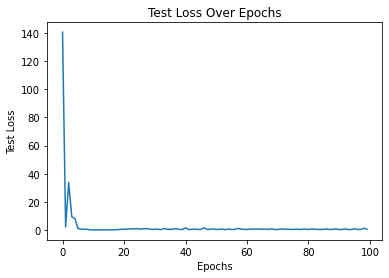

In [18]:
# Run the main function
if __name__ == "__main__":

    #print('OPTIONS ', options)
    # Tuning Parameters:
    import easydict
    from argparse import ArgumentParser
    parser = ArgumentParser()
    args = parser.parse_known_args()[0]
    #使用 easydict，可以创建一个命名空间对象，该对象具有字典的功能，并允许通过点号操作符来访问和设置键值对。
    args = easydict.EasyDict({
            "num_epochs": 100,
            "batch_size": 1,
            "lr": 0.0005,
            "tb_dir": "./runs",
            "final": False,
            "max_pool": False,
            "embedding_size" : 1024,
            "vocab_size" : 50000,
            "max_length" : 520,
            "num_heads" : 2,
            "depth" : 1,
            "seed" : 1,
            "lr_warmup" : 500,
            "gradient_clipping" : 1.0
    })
    evaluation = go(args)

    epoch_numbers = evaluation['epoch']
    test_accuracies = evaluation['Test Accuracy']

    # 将数据转换为 NumPy 数组
    epoch_numbers = np.array(epoch_numbers)
    test_accuracies = np.array(test_accuracies)

    # 获取排序后的索引
    sorted_indices = np.argsort(epoch_numbers)

    # 根据排序后的索引获取排序后的数据
    sorted_epoch_numbers = epoch_numbers[sorted_indices]
    sorted_test_accuracies = test_accuracies[sorted_indices]

    # 绘制迭代MSE折线图
    plt.plot(sorted_epoch_numbers, sorted_test_accuracies)
    plt.xlabel('Epochs')
    plt.ylabel('Test Loss')  # 或者 'Test Accuracy'，具体根据你的情况来确定
    plt.title('Test Loss Over Epochs')
    plt.show()